#### Решение


Используя базу "Пассажиры автобуса", подготовьте данные для обучения нейронной сети, классифицирующей изображение на два класса:
- входящий пассажир
- выходящий пассажир

Добейтесь точности работы модели на проверочной выборке не ниже 85%

Ссылка на датасет: https://storage.yandexcloud.net/aiueducation/Content/base/l4/bus.zip

Информацию о загрузке изображений и преобразовании их в numnpy-массивы вы можете найти в Базе знаний:


In [1]:
# Библиотека для сбора мусора
import gc

# Библиотека работы с массивами
import numpy as np

# Для отрисовки графиков
import matplotlib.pyplot as plt

# Для работы с файлами
import os

# Для генерации случайных чисел
import random

# модуль для отсчета времени
import time

# импортируем модуль для загрузки данных
import gdown

# методы для отрисовки изображений
from PIL import Image

# для разделения выборок
from sklearn.model_selection import train_test_split

# для преобразования строковых меток в числовые
from sklearn.preprocessing import LabelEncoder

# для создания сети
from tensorflow.keras.models import Sequential

# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# для работы с изображениями
from tensorflow.keras.preprocessing import image

# оптимизатор
from tensorflow.keras.optimizers import Adam


In [2]:
gc.enable()

In [3]:
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l4/bus.zip')

!unzip -q "bus.zip" -d /content/UltraPro

IMAGE_PATH = '/content/UltraPro/'

os.listdir(IMAGE_PATH)

Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l4/bus.zip
To: /content/bus.zip
100%|██████████| 78.6M/78.6M [00:04<00:00, 19.0MB/s]


['Входящий', 'Выходящий']

In [4]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}')
print(f'Метки классов: {CLASS_LIST}')

Количество классов: 2
Метки классов: ['Входящий', 'Выходящий']


(150, 230)
(224, 297)


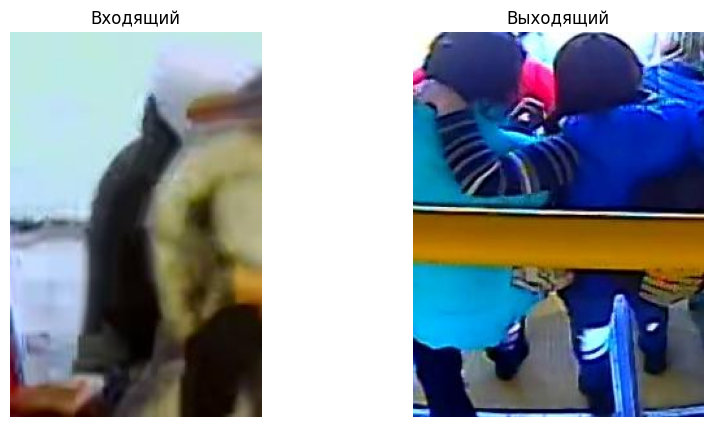

In [5]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):

    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'

    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))
    print(Image.open(img_path).size)


    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [6]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} фото')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print()
print('Общий размер базы для обучения:', len(data_labels))

Размер класса Входящий составляет 6485 фото
Размер класса Выходящий составляет 2596 фото

Общий размер базы для обучения: 9081


In [7]:
x_org = []
y_org = []
# Задание высоты и ширины загружаемых изображений
img_height = 200
img_width = 200
j = 0
for i in data_files:
  x_org.append(image.img_to_array(image.load_img(i, target_size=(img_height, img_width))))
  y_org.append(data_labels[j])
  j+=1

In [8]:
del data_files
del data_labels

In [9]:
# Преобразование в numpy-массив загруженных изображений и меток классов
x_org_t = np.array(x_org)
y_org_t = np.array(y_org)

# Вывод размерностей
print('Размер массива x_train', x_org_t.shape)
print('Размер массива x_train', y_org_t.shape)

Размер массива x_train (9081, 200, 200, 3)
Размер массива x_train (9081,)


In [10]:
del x_org
del y_org

## модель


In [11]:
# Разделение данных на обучающий и тестовый наборы (80% обучающие, 20% тестовые)
x_train, x_test, y_train, y_test = train_test_split(x_org_t, y_org_t, test_size=0.2, random_state=42)

# Вывод размеров обучающего и тестового наборов
print("Размер обучающего набора:", len(x_train))
print("Размер тестового набора:", len(x_test))

Размер обучающего набора: 7264
Размер тестового набора: 1817


In [12]:
del x_org_t
del y_org_t

In [13]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(7264, 200, 200, 3)
(7264,)
(1817, 200, 200, 3)
(1817,)


In [14]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# Проверка результата
print(f'Форма обучающих данных: {x_train.shape}')
print(f'Форма  тестовых данных: {x_test.shape}')

Форма обучающих данных: (7264, 120000)
Форма  тестовых данных: (1817, 120000)


In [15]:
print(f'Форма обучающих данных: {y_train.shape}')
print(f'Форма  тестовых данных: {y_test.shape}')

Форма обучающих данных: (7264,)
Форма  тестовых данных: (1817,)


In [16]:
# Нормализация входных картинок
# Преобразование x_train в тип float32 (числа с плавающей точкой) и нормализация
x_train = x_train.astype('float32') / 255.

# Преобразование x_test в тип float32 (числа с плавающей точкой) и нормализация
x_test = x_test.astype('float32') / 255.

In [17]:
gc.collect()

93

In [18]:
# Создание модели
model = Sequential()

# Добавление слоев
model.add(Dense(100, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [19]:
gc.collect()

232

In [20]:
# Обучение модели
history = model.fit(x_train,       # Обучающая выборка параметров
          y_train,       # Обучающая выборка меток класса
          batch_size=132,  # Размер батча (пакета)
          epochs=30,    # Количество эпох обучения
          validation_split=0.2,  # Доля проверочной выборки
          verbose=1)     # Отображение хода обучения

Epoch 1/30
45/45 [==============================] - 27s 573ms/step - loss: 4.6895 - accuracy: 0.6130 - val_loss: 0.8722 - val_accuracy: 0.7233
Epoch 2/30
45/45 [==============================] - 23s 520ms/step - loss: 0.6197 - accuracy: 0.7188 - val_loss: 1.3413 - val_accuracy: 0.7034
Epoch 3/30
45/45 [==============================] - 24s 533ms/step - loss: 0.6553 - accuracy: 0.7343 - val_loss: 0.7699 - val_accuracy: 0.5182
Epoch 4/30
45/45 [==============================] - 22s 498ms/step - loss: 0.7559 - accuracy: 0.6997 - val_loss: 0.4722 - val_accuracy: 0.7805
Epoch 5/30
45/45 [==============================] - 25s 553ms/step - loss: 0.5005 - accuracy: 0.7685 - val_loss: 0.5583 - val_accuracy: 0.7619
Epoch 6/30
45/45 [==============================] - 25s 553ms/step - loss: 0.4462 - accuracy: 0.7992 - val_loss: 0.4178 - val_accuracy: 0.8197
Epoch 7/30
45/45 [==============================] - 24s 527ms/step - loss: 0.4439 - accuracy: 0.7985 - val_loss: 0.8721 - val_accuracy: 0.7164

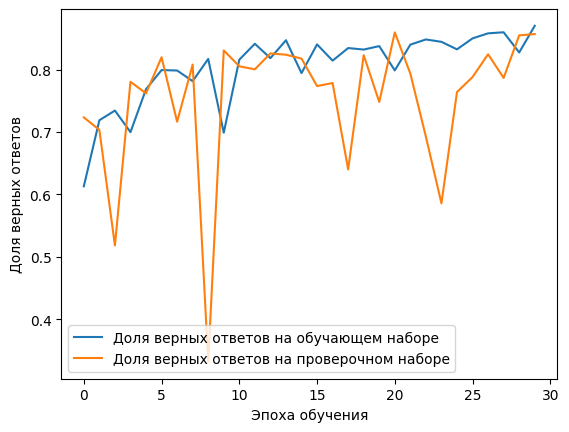

In [21]:
# Визуализация точности на обучающей выборке

plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')

# Визуализация точности на проверочной выборке
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')

# Отрисовка подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Отрисовка легенды
plt.legend()

# Вывод графика
plt.show()

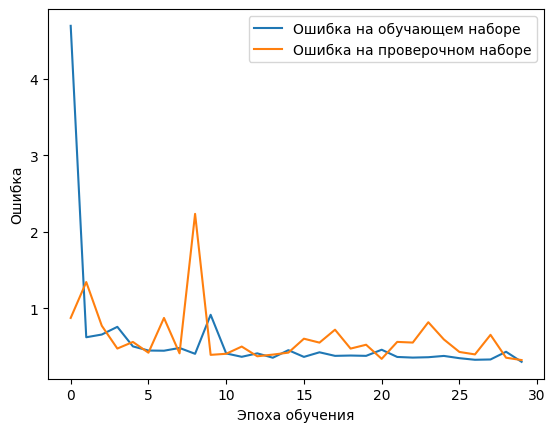

In [22]:
# Вывод графика ошибки
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()


In [23]:
gc.collect()

8671

In [24]:
scores = model.evaluate(x_test, y_test, verbose=1)

print(scores)
print('Доля верных ответов на тестовых данных, в процентах: {:7.4%}'.format(scores[1]))

57/57 [==============================] - 2s 38ms/step - loss: 0.3421 - accuracy: 0.8498
[0.34212106466293335, 0.8497523665428162]
Доля верных ответов на тестовых данных, в процентах: 84.9752%
